<a href="https://colab.research.google.com/github/maugarciav/tc3002b-IA/blob/main/ModeloBrainTumor_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thomasdubail/brain-tumors-256x256")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumors-256x256


In [6]:
!ls /kaggle/input/brain-tumors-256x256/Data


glioma_tumor  meningioma_tumor	normal	pituitary_tumor


# Data Augmentation

usamos ImageDataGenerator para generar imagenes nuevas en el ram mientras entrenamos para no desperdiciar espacio.

Found 2479 images belonging to 4 classes.
Found 617 images belonging to 4 classes.
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}
Tamaño del conjunto de entrenamiento: 2479
Tamaño del conjunto de validación: 617


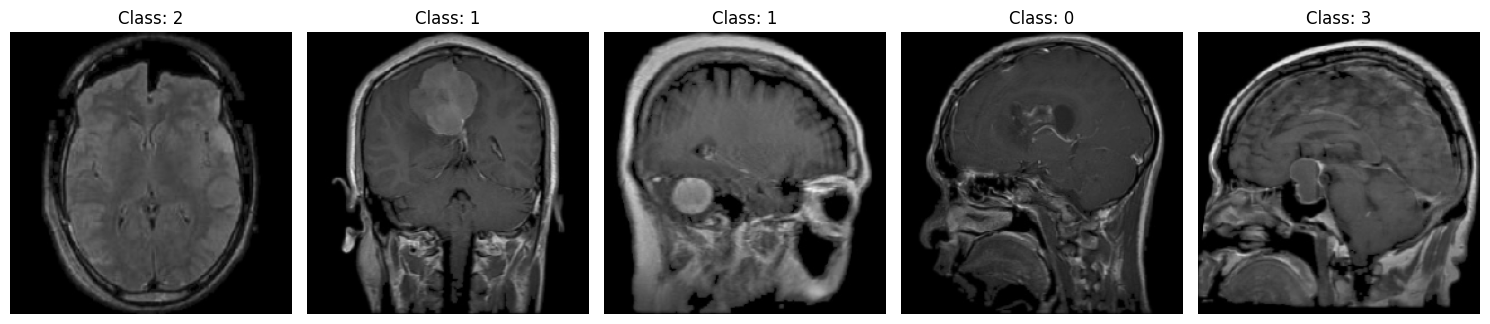

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers




base_dir = '/kaggle/input/brain-tumors-256x256/Data'

# ImageDataGenerator para entrenamiento y validación
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.18,
    horizontal_flip=True,
    validation_split=0.2
)

# Generador para el conjunto de entrenamiento
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=16,
    subset='training',
    class_mode='sparse',
    seed=42,
    shuffle=True
)

# Generador para el conjunto de validación
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=16,
    subset='validation',
    class_mode='sparse',
    seed=42,
    shuffle=False
)

print("Class indices:", train_generator.class_indices)
print("Tamaño del conjunto de entrenamiento:", train_generator.samples)
print("Tamaño del conjunto de validación:", validation_generator.samples)

plt.figure(figsize=(15, 4))
for i in range(5):
    images, labels = next(train_generator)
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[0])
    plt.title(f"Class: {int(labels[0])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Esta es una red neuronal convolutiva:

In [8]:
# Mapeo de índices de clase a nombres de clase
reverse_classes = {v: k for k, v in train_generator.class_indices.items()}
num_classes = len(reverse_classes)

In [9]:
sample_images = []
sample_labels = []
classes_seen = set()

# Iterar sobre el generador hasta obtener una muestra de cada clase
while len(classes_seen) < num_classes:
    images, labels = next(train_generator)
    for i in range(len(labels)):
        label = int(labels[i])
        if label not in classes_seen:
            sample_images.append(images[i])
            sample_labels.append(label)
            classes_seen.add(label)
            if len(classes_seen) == num_classes:
                break
    if len(classes_seen) == num_classes:
        break

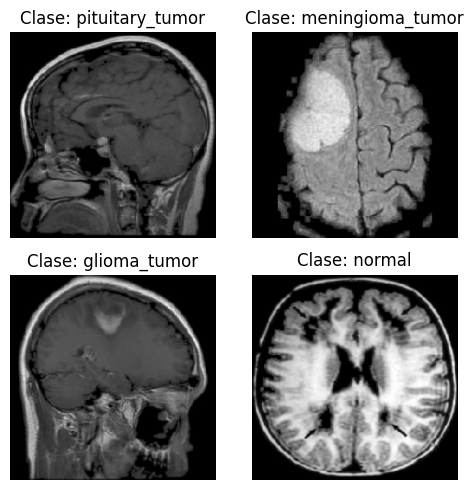

In [10]:
fig = plt.figure(figsize=(5, 5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 2, i + 1)
    plt.imshow(sample_images[i])
    ax.set_title(f'Clase: {reverse_classes[sample_labels[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

train_generator.reset()

In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

model = models.Sequential()

# Convolutional Layers with Varied Dropout and L2
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3),
                        kernel_regularizer=regularizers.l2(5e-4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.15))

model.add(layers.Conv2D(64, (3, 3), activation="relu",
                        kernel_regularizer=regularizers.l2(5e-4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation="relu",
                        kernel_regularizer=regularizers.l2(5e-4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

# Fully Connected Layers with Dropout
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu',
                kernel_constraint=tf.keras.constraints.MaxNorm(3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizers.Adam(learning_rate=1e-4),
            metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 71s 398ms/step - accuracy: 0.3191 - loss: 1.4416 - val_accuracy: 0.4688 - val_loss: 1.3021
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.4982 - loss: 1.1957 - val_accuracy: 0.5559 - val_loss: 1.1808
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.6071 - loss: 0.9839 - val_accuracy: 0.5724 - val_loss: 1.0581
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 252ms/step - accuracy: 0.6840 - loss: 0.8715 - val_accuracy: 0.6135 - val_loss: 0.9928
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 247ms/step - accuracy: 0.7138 - loss: 0.7733 - val_accuracy: 0.6447 - val_loss: 0.9129
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step - accuracy: 0.7692 - loss: 0.6747 - val_accuracy: 0.6628 - val_loss: 0.8134
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.7862 - loss: 0.6018 - val_accuracy: 0.6826 - val_loss: 0.8359
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - accuracy: 0.8054 - loss: 0

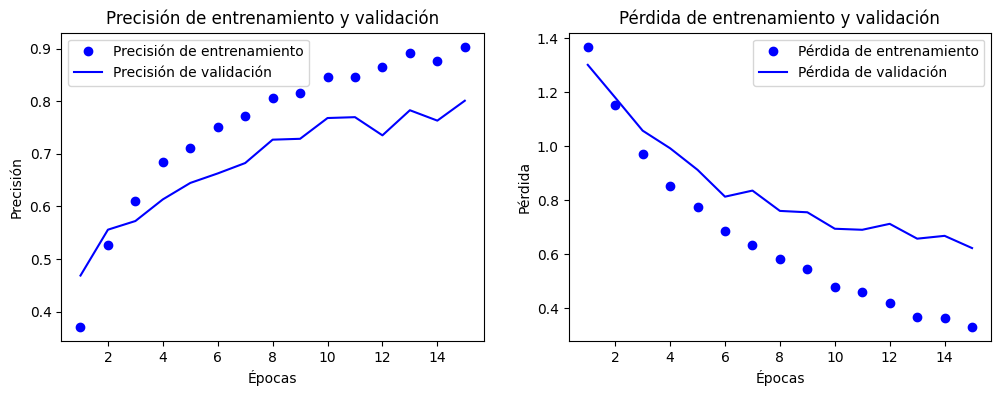

In [12]:
history = model.fit(
						train_generator,
						epochs = 15,
						validation_data=validation_generator,
   					validation_steps=validation_generator.samples // validation_generator.batch_size
						)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [13]:
eval_loss, eval_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'\nPérdida en el conjunto de validación: {eval_loss:.4f}')
print(f'Precisión en el conjunto de validación: {eval_acc:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.7791 - loss: 0.6931

Pérdida en el conjunto de validación: 0.6187
Precisión en el conjunto de validación: 0.8026


In [15]:
model.save('modelo_deteccion_tumores.keras')
print("Modelo guardado exitosamente en el archivo 'modelo_deteccion_tumores.keras'")

Modelo guardado exitosamente en el archivo 'modelo_deteccion_tumores.keras'


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score

# Etiquetas verdaderas y las predicciones para el conjunto de validación
true_labels = validation_generator.classes
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)

# Asegurémonos de que la longitud de las etiquetas predichas coincida con las verdaderas
if len(predicted_classes) > len(true_labels):
    predicted_classes = predicted_classes[:len(true_labels)]
elif len(predicted_classes) < len(true_labels):
    true_labels = true_labels[:len(predicted_classes)]


# Calcular Recall y F1-Score
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

print(f'Recall en el conjunto de validación: {recall:.4f}')
print(f'F1-Score en el conjunto de validación: {f1:.4f}')

# Mostrar el informe de clasificación completo
report = classification_report(true_labels, predicted_classes, target_names=list(train_generator.class_indices.keys()))
print("\nInforme de Clasificación en el conjunto de validación:\n", report)


cm = confusion_matrix(true_labels, predicted_classes)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step
Recall en el conjunto de validación: 0.8026
F1-Score en el conjunto de validación: 0.8001

Informe de Clasificación en el conjunto de validación:
                   precision    recall  f1-score   support

    glioma_tumor       0.81      0.79      0.80       180
meningioma_tumor       0.76      0.68      0.72       182
          normal       0.78      0.84      0.81        87
 pituitary_tumor       0.85      0.94      0.89       159

        accuracy                           0.80       608
       macro avg       0.80      0.81      0.80       608
    weighted avg       0.80      0.80      0.80       608



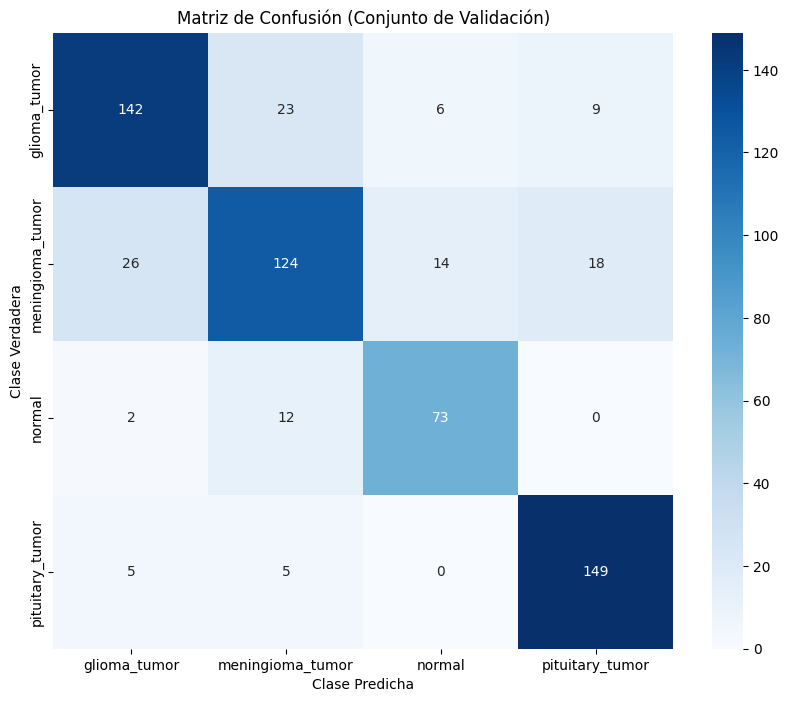

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión (Conjunto de Validación)')
plt.show()

Found 617 images belonging to 4 classes.


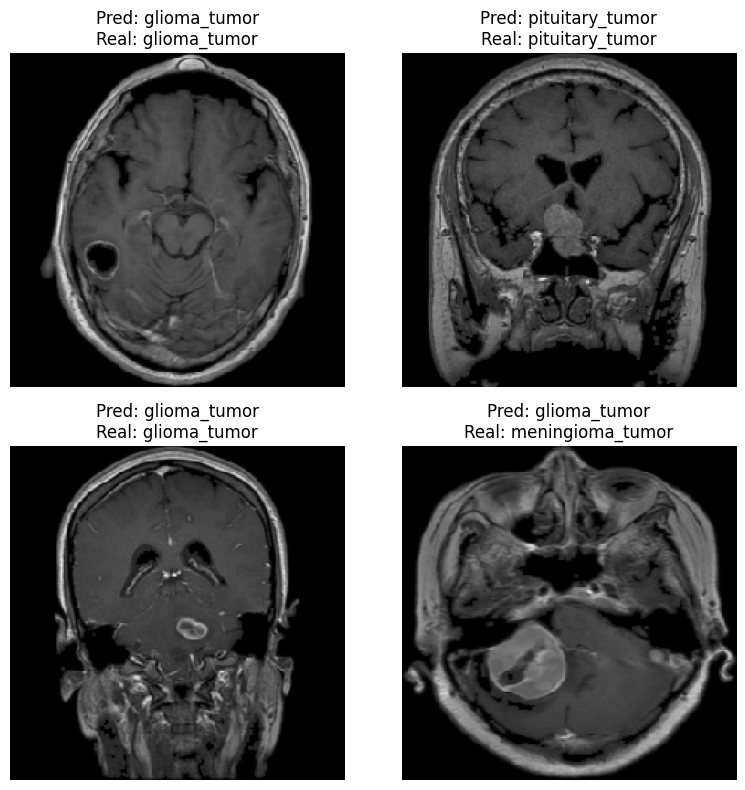

In [18]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

eval_generator_visual = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=4,
    subset='validation',
    class_mode='sparse',
    seed=42,
    shuffle=True
)

class_names = list(eval_generator_visual.class_indices.keys())

images, true_labels = next(eval_generator_visual)
predictions = model.predict(images, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
images_desnormalizadas = (images * 255).astype(np.uint8)


fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
for i in range(eval_generator_visual.batch_size):
    ax = axes[i]
    ax.imshow(images_desnormalizadas[i])
    predicted_label = class_names[predicted_classes[i]]
    true_label = class_names[true_labels[i].astype(int)]
    ax.set_title(f"Pred: {predicted_label}\nReal: {true_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()
